# Extended Analysis: RL Optimal Rules with Long-Term Data

## Investigating Whether Instantaneous Method Remains Optimal

**Motivation:** The previous notebook (04) showed that instantaneous method was ALWAYS better in short-term simulations (200 µs). This notebook extends the analysis to:

1. **Longer simulation periods** (up to 10 ms - 50x longer)
2. **More diverse data** (10+ frequencies, different Q factors)
3. **More transient scenarios** (switching events, frequency sweeps)
4. **Advanced RL techniques** (deeper networks, multi-objective rewards)

**Key Question:** *Will averaging method become competitive in steady-state regions with longer simulation times?*

---

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import differential_evolution
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Callable
from enum import Enum
from functools import partial
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plot settings
plt.rcParams.update({
    'font.size': 11,
    'figure.figsize': (14, 7),
    'axes.grid': True,
    'grid.alpha': 0.3
})

print("✓ Imports successful")
print(f"NumPy version: {np.__version__}")

✓ Imports successful
NumPy version: 2.3.5


---
## 1. Enhanced Circuit Simulator with Variable Parameters

In [2]:
@dataclass
class CircuitParams:
    """Extended circuit parameters with variable Q factor"""
    L: float = 100.04e-6    # Inductance [H]
    C: float = 30.07e-9     # Capacitance [F]
    Rs: float = 3.0         # Series resistance [Ω]
    Ro: float = 2000.0      # Load resistance [Ω]
    
    @property
    def omega_r(self) -> float:
        """Resonant frequency"""
        return 1.0 / np.sqrt(self.L * self.C)
    
    @property
    def Q(self) -> float:
        """Quality factor"""
        return (1.0 / self.Rs) * np.sqrt(self.L / self.C)
    
    @classmethod
    def with_Q(cls, Q_target: float) -> 'CircuitParams':
        """Create circuit with specific Q factor"""
        L = 100.04e-6
        C = 30.07e-9
        Rs = (1.0 / Q_target) * np.sqrt(L / C)
        return cls(L=L, C=C, Rs=Rs, Ro=2000.0)


class EnhancedCircuitSimulator:
    """
    Enhanced simulator with time-varying source capabilities.
    """
    
    def __init__(self, params: CircuitParams = None):
        self.params = params or CircuitParams()
    
    def time_domain_ode(self, t, state, source_func):
        """Time-domain state equations with arbitrary source"""
        i_s, v_o = state
        p = self.params
        
        vs = source_func(t)
        
        di_dt = (vs - p.Rs * i_s - v_o) / p.L
        dv_dt = (i_s - v_o / p.Ro) / p.C
        
        return [di_dt, dv_dt]
    
    def phasor_domain_ode(self, t, state, omega_s, Ve=1.0, envelope_func=None):
        """Phasor-domain with optional time-varying envelope"""
        i_re, i_im, v_re, v_im = state
        i_s = i_re + 1j * i_im
        v_o = v_re + 1j * v_im
        
        p = self.params
        
        # Time-varying envelope
        if envelope_func is not None:
            Ve = envelope_func(t)
        
        vs_phasor = Ve + 0j
        
        X_L = omega_s * p.L
        X_C = -1.0 / (omega_s * p.C)
        
        di_phasor = (vs_phasor - (p.Rs + 1j * X_L) * i_s - v_o) / p.L
        dv_phasor = (i_s - v_o / p.Ro - v_o / (1j * X_C)) / p.C
        
        return [np.real(di_phasor), np.imag(di_phasor),
                np.real(dv_phasor), np.imag(dv_phasor)]
    
    def simulate_ground_truth(self, source_func, t_span, n_points=10000):
        """High-fidelity time-domain simulation"""
        t_eval = np.linspace(t_span[0], t_span[1], n_points)
        
        sol = solve_ivp(
            lambda t, y: self.time_domain_ode(t, y, source_func),
            t_span, [0.0, 0.0],
            t_eval=t_eval,
            method='RK45',
            rtol=1e-10, atol=1e-12
        )
        
        return {
            't': sol.t,
            'i_s': sol.y[0],
            'v_o': sol.y[1]
        }
    
    def simulate_instantaneous(self, omega_s, t_span, n_points=2000, envelope_func=None):
        """Instantaneous phasor simulation"""
        t_eval = np.linspace(t_span[0], t_span[1], n_points)
        
        sol = solve_ivp(
            lambda t, y: self.phasor_domain_ode(t, y, omega_s, envelope_func=envelope_func),
            t_span, [0.0, 0.0, 0.0, 0.0],
            t_eval=t_eval,
            method='RK45',
            rtol=1e-8, atol=1e-10
        )
        
        i_phasor = sol.y[0] + 1j * sol.y[1]
        v_phasor = sol.y[2] + 1j * sol.y[3]
        
        i_s = np.real(i_phasor * np.exp(1j * omega_s * sol.t))
        v_o = np.real(v_phasor * np.exp(1j * omega_s * sol.t))
        
        return {
            't': sol.t,
            'i_s': i_s,
            'v_o': v_o,
            'i_envelope': np.abs(i_phasor),
            'v_envelope': np.abs(v_phasor),
            'i_phasor': i_phasor,
            'v_phasor': v_phasor
        }
    
    def simulate_averaging(self, omega_s, t_span, n_points=2000, envelope_func=None):
        """Generalized averaging with coarser tolerances"""
        # Use fewer time points for averaging (simulates coarser method)
        t_eval_coarse = np.linspace(t_span[0], t_span[1], n_points // 3)
        
        sol = solve_ivp(
            lambda t, y: self.phasor_domain_ode(t, y, omega_s, envelope_func=envelope_func),
            t_span, [0.0, 0.0, 0.0, 0.0],
            t_eval=t_eval_coarse,
            method='RK45',
            rtol=1e-5, atol=1e-7  # Coarser tolerance
        )
        
        # Interpolate to full time grid
        from scipy.interpolate import interp1d
        t_full = np.linspace(t_span[0], t_span[1], n_points)
        
        i_phasor = sol.y[0] + 1j * sol.y[1]
        v_phasor = sol.y[2] + 1j * sol.y[3]
        
        # Interpolate complex phasors
        i_re_interp = interp1d(sol.t, np.real(i_phasor), kind='linear', fill_value='extrapolate')
        i_im_interp = interp1d(sol.t, np.imag(i_phasor), kind='linear', fill_value='extrapolate')
        v_re_interp = interp1d(sol.t, np.real(v_phasor), kind='linear', fill_value='extrapolate')
        v_im_interp = interp1d(sol.t, np.imag(v_phasor), kind='linear', fill_value='extrapolate')
        
        i_phasor_full = i_re_interp(t_full) + 1j * i_im_interp(t_full)
        v_phasor_full = v_re_interp(t_full) + 1j * v_im_interp(t_full)
        
        i_s = np.real(i_phasor_full * np.exp(1j * omega_s * t_full))
        v_o = np.real(v_phasor_full * np.exp(1j * omega_s * t_full))
        
        return {
            't': t_full,
            'i_s': i_s,
            'v_o': v_o,
            'i_envelope': np.abs(i_phasor_full),
            'v_envelope': np.abs(v_phasor_full)
        }


# Test with different Q factors
print("Testing circuit configurations:")
for Q in [5, 10, 20, 50]:
    params = CircuitParams.with_Q(Q)
    print(f"  Q = {Q:2d}: Rs = {params.Rs:.3f} Ω, ω_r = {params.omega_r/1e3:.1f} krad/s")

print("\n✓ Enhanced simulator ready")

Testing circuit configurations:
  Q =  5: Rs = 11.536 Ω, ω_r = 576.6 krad/s
  Q = 10: Rs = 5.768 Ω, ω_r = 576.6 krad/s
  Q = 20: Rs = 2.884 Ω, ω_r = 576.6 krad/s
  Q = 50: Rs = 1.154 Ω, ω_r = 576.6 krad/s

✓ Enhanced simulator ready


---
## 2. Generate Extended Dataset with Diverse Scenarios

In [3]:
def create_source_functions():
    """Create diverse source function scenarios"""
    
    scenarios = {
        # Scenario 1: Pure step (original)
        'step': lambda omega_s: lambda t: np.cos(omega_s * t) if t >= 0 else 0.0,
        
        # Scenario 2: Slow amplitude modulation (10% at 10 kHz)
        'slow_mod': lambda omega_s: lambda t: (1.0 + 0.1 * np.sin(2*np.pi*10e3*t)) * np.cos(omega_s * t),
        
        # Scenario 3: Step change at t=1ms
        'step_change': lambda omega_s: lambda t: (0.5 if t < 1e-3 else 1.0) * np.cos(omega_s * t),
        
        # Scenario 4: Exponential rise
        'exp_rise': lambda omega_s: lambda t: (1 - np.exp(-t/0.5e-3)) * np.cos(omega_s * t),
        
        # Scenario 5: Switching at regular intervals
        'switching': lambda omega_s: lambda t: (0.5 + 0.5 * np.sign(np.sin(2*np.pi*5e3*t))) * np.cos(omega_s * t),
        
        # Scenario 6: Frequency sweep (chirp)
        'chirp': lambda omega_s: lambda t: np.cos(omega_s * t + 1e9 * t**2),
    }
    
    return scenarios


def compute_extended_features(result_dict, omega_s, params, window_size=50):
    """
    Extract comprehensive features from simulation results.
    
    Enhanced with:
    - Spectral features (FFT-based)
    - Local variability measures
    - Phase information
    """
    t = result_dict['t']
    i_s = result_dict['i_s']
    v_o = result_dict['v_o']
    dt = t[1] - t[0]
    n = len(t)
    
    features = []
    
    for i in range(n):
        f = {}
        
        # Time features
        f['time'] = t[i]
        f['time_normalized'] = t[i] / t[-1]
        f['time_us'] = t[i] * 1e6
        f['time_ms'] = t[i] * 1e3
        
        # Instantaneous values
        f['i_s_mag'] = np.abs(i_s[i])
        f['v_o_mag'] = np.abs(v_o[i])
        
        # Derivatives
        if i > 0 and i < n - 1:
            f['di_dt'] = (i_s[i+1] - i_s[i-1]) / (2 * dt)
            f['dv_dt'] = (v_o[i+1] - v_o[i-1]) / (2 * dt)
        else:
            f['di_dt'] = 0.0
            f['dv_dt'] = 0.0
        
        # Second derivatives
        if i > 1 and i < n - 2:
            f['d2i_dt2'] = (i_s[i+1] - 2*i_s[i] + i_s[i-1]) / (dt**2)
            f['d2v_dt2'] = (v_o[i+1] - 2*v_o[i] + v_o[i-1]) / (dt**2)
        else:
            f['d2i_dt2'] = 0.0
            f['d2v_dt2'] = 0.0
        
        # Normalized derivatives
        i_max = max(np.abs(i_s)) + 1e-10
        v_max = max(np.abs(v_o)) + 1e-10
        f['di_dt_norm'] = np.abs(f['di_dt']) / i_max
        f['dv_dt_norm'] = np.abs(f['dv_dt']) / v_max
        
        # Local envelope variation (moving window)
        if i >= window_size:
            i_window = i_s[i-window_size:i+1]
            v_window = v_o[i-window_size:i+1]
            
            i_env = np.abs(i_window)
            v_env = np.abs(v_window)
            
            f['i_envelope_var'] = np.std(i_env) / (np.mean(i_env) + 1e-10)
            f['v_envelope_var'] = np.std(v_env) / (np.mean(v_env) + 1e-10)
            
            # Local trend (slope of envelope)
            if np.mean(i_env) > 1e-6:
                t_win = np.arange(window_size + 1) * dt
                i_slope = np.polyfit(t_win, i_env, 1)[0]
                f['i_envelope_slope'] = i_slope / np.mean(i_env)
            else:
                f['i_envelope_slope'] = 0.0
        else:
            f['i_envelope_var'] = 1.0
            f['v_envelope_var'] = 1.0
            f['i_envelope_slope'] = 0.0
        
        # Frequency features
        f['omega_s'] = omega_s
        f['omega_r'] = params.omega_r
        f['freq_ratio'] = omega_s / params.omega_r
        f['detuning'] = abs(omega_s - params.omega_r) / params.omega_r
        f['Q_factor'] = params.Q
        
        # Circuit-specific features
        f['Rs'] = params.Rs
        
        features.append(f)
    
    return pd.DataFrame(features)


def compute_errors_extended(truth, inst, avg):
    """Compute comprehensive error metrics"""
    from scipy.interpolate import interp1d
    
    t = truth['t']
    
    # Interpolate
    inst_i_interp = interp1d(inst['t'], inst['i_s'], fill_value='extrapolate')
    inst_v_interp = interp1d(inst['t'], inst['v_o'], fill_value='extrapolate')
    avg_i_interp = interp1d(avg['t'], avg['i_s'], fill_value='extrapolate')
    avg_v_interp = interp1d(avg['t'], avg['v_o'], fill_value='extrapolate')
    
    # Point-wise absolute errors
    err_inst_i = np.abs(truth['i_s'] - inst_i_interp(t))
    err_inst_v = np.abs(truth['v_o'] - inst_v_interp(t))
    err_avg_i = np.abs(truth['i_s'] - avg_i_interp(t))
    err_avg_v = np.abs(truth['v_o'] - avg_v_interp(t))
    
    # Combined metric (normalized)
    v_scale = 10.0  # Voltage scaling factor
    err_inst = np.sqrt(err_inst_i**2 + (err_inst_v/v_scale)**2)
    err_avg = np.sqrt(err_avg_i**2 + (err_avg_v/v_scale)**2)
    
    # Relative errors
    i_ref = np.abs(truth['i_s']) + 1e-6
    v_ref = np.abs(truth['v_o']) + 1e-3
    
    err_inst_rel = err_inst / np.sqrt(i_ref**2 + (v_ref/v_scale)**2)
    err_avg_rel = err_avg / np.sqrt(i_ref**2 + (v_ref/v_scale)**2)
    
    return {
        't': t,
        'err_inst': err_inst,
        'err_avg': err_avg,
        'err_inst_rel': err_inst_rel,
        'err_avg_rel': err_avg_rel,
        'err_inst_i': err_inst_i,
        'err_inst_v': err_inst_v,
        'err_avg_i': err_avg_i,
        'err_avg_v': err_avg_v,
        'better_method': (err_avg < err_inst).astype(int)
    }


print("✓ Extended feature extraction functions defined")

✓ Extended feature extraction functions defined


---
## 3. Generate Large-Scale Dataset

**Parameters:**
- Simulation time: **10 ms** (50× longer than original)
- Time points: 5,000 per simulation
- Frequencies: 12 different values
- Q factors: 4 values (5, 10, 20, 50)
- Scenarios: 6 types

**Total data points:** 12 freq × 4 Q × 6 scenarios × 5,000 points = **1,440,000 points**

In [4]:
print("="*80)
print("GENERATING EXTENDED DATASET")
print("="*80)

# Extended parameters
t_span_long = (0, 10e-3)  # 10 ms - 50x longer!
n_points = 5000  # More points for longer simulation

# More frequencies (including off-resonance)
frequencies = np.linspace(400e3, 800e3, 12)  # 12 frequencies from 400-800 krad/s

# Different Q factors
Q_factors = [5, 10, 20, 50]

# Different scenarios
source_scenarios = create_source_functions()
scenario_names = list(source_scenarios.keys())

print(f"\nConfiguration:")
print(f"  Simulation time: {t_span_long[1]*1e3:.1f} ms")
print(f"  Points per simulation: {n_points:,}")
print(f"  Frequencies: {len(frequencies)}")
print(f"  Q factors: {Q_factors}")
print(f"  Scenarios: {scenario_names}")
print(f"  Expected total points: {len(frequencies) * len(Q_factors) * len(scenario_names) * n_points:,}")
print(f"\nStarting generation...\n")

all_data = []
start_time = time.time()
total_sims = len(frequencies) * len(Q_factors) * len(scenario_names)
sim_count = 0

# Generate data
for Q in Q_factors:
    params = CircuitParams.with_Q(Q)
    sim = EnhancedCircuitSimulator(params)
    
    for omega_s in frequencies:
        for scenario_name in scenario_names:
            sim_count += 1
            
            if sim_count % 5 == 0 or sim_count == 1:
                elapsed = time.time() - start_time
                progress = sim_count / total_sims
                eta = (elapsed / progress - elapsed) if progress > 0 else 0
                
                print(f"  [{sim_count:3d}/{total_sims}] Q={Q:2d}, ω={omega_s/1e3:5.0f} krad/s, "
                      f"{scenario_name:12s} | ETA: {eta/60:4.1f}m")
            
            # Get source function
            source_func = source_scenarios[scenario_name](omega_s)
            envelope_func = None  # Will use source_func for time-domain
            
            # For phasor methods, extract envelope
            if scenario_name == 'step':
                envelope_func = None  # Unit envelope
            elif scenario_name == 'slow_mod':
                envelope_func = lambda t: 1.0 + 0.1 * np.sin(2*np.pi*10e3*t)
            elif scenario_name == 'step_change':
                envelope_func = lambda t: 0.5 if t < 1e-3 else 1.0
            elif scenario_name == 'exp_rise':
                envelope_func = lambda t: 1 - np.exp(-t/0.5e-3)
            elif scenario_name == 'switching':
                envelope_func = lambda t: 0.5 + 0.5 * np.sign(np.sin(2*np.pi*5e3*t))
            elif scenario_name == 'chirp':
                envelope_func = None  # Frequency varies, use base
            
            try:
                # Ground truth (time-domain)
                truth = sim.simulate_ground_truth(source_func, t_span_long, n_points * 2)
                
                # Instantaneous
                inst = sim.simulate_instantaneous(omega_s, t_span_long, n_points, envelope_func)
                
                # Averaging
                avg = sim.simulate_averaging(omega_s, t_span_long, n_points, envelope_func)
                
                # Extract features
                features = compute_extended_features(truth, omega_s, params)
                
                # Compute errors
                errors = compute_errors_extended(truth, inst, avg)
                
                # Combine
                features['err_inst'] = np.interp(features['time'], errors['t'], errors['err_inst'])
                features['err_avg'] = np.interp(features['time'], errors['t'], errors['err_avg'])
                features['err_inst_rel'] = np.interp(features['time'], errors['t'], errors['err_inst_rel'])
                features['err_avg_rel'] = np.interp(features['time'], errors['t'], errors['err_avg_rel'])
                features['better_method'] = (features['err_avg'] < features['err_inst']).astype(int)
                
                # Add metadata
                features['scenario'] = scenario_name
                features['Q'] = Q
                
                all_data.append(features)
                
            except Exception as e:
                print(f"    ⚠️ Error in simulation: {e}")
                continue

# Combine all data
df_extended = pd.concat(all_data, ignore_index=True)

total_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"✅ DATASET GENERATION COMPLETE")
print(f"{'='*80}")
print(f"Total time: {total_time/60:.1f} minutes ({total_time:.0f}s)")
print(f"Data points: {len(df_extended):,}")
print(f"Features: {len(df_extended.columns)} columns")
print(f"\nClass distribution:")
print(f"  Instantaneous better: {(df_extended['better_method']==0).sum():,} ({(df_extended['better_method']==0).mean()*100:.2f}%)")
print(f"  Averaging better: {(df_extended['better_method']==1).sum():,} ({(df_extended['better_method']==1).mean()*100:.2f}%)")
print(f"\nScenario breakdown:")
for scenario in scenario_names:
    subset = df_extended[df_extended['scenario'] == scenario]
    avg_better = (subset['better_method'] == 1).mean() * 100
    print(f"  {scenario:15s}: {avg_better:5.2f}% averaging better")

GENERATING EXTENDED DATASET

Configuration:
  Simulation time: 10.0 ms
  Points per simulation: 5,000
  Frequencies: 12
  Q factors: [5, 10, 20, 50]
  Scenarios: ['step', 'slow_mod', 'step_change', 'exp_rise', 'switching', 'chirp']
  Expected total points: 1,440,000

Starting generation...

  [  1/288] Q= 5, ω=  400 krad/s, step         | ETA:  0.0m
  [  5/288] Q= 5, ω=  400 krad/s, switching    | ETA: 32.7m
  [ 10/288] Q= 5, ω=  436 krad/s, exp_rise     | ETA: 47.5m
  [ 15/288] Q= 5, ω=  473 krad/s, step_change  | ETA: 51.8m
  [ 20/288] Q= 5, ω=  509 krad/s, slow_mod     | ETA: 53.3m
  [ 25/288] Q= 5, ω=  545 krad/s, step         | ETA: 54.1m
  [ 30/288] Q= 5, ω=  545 krad/s, chirp        | ETA: 51.2m
  [ 35/288] Q= 5, ω=  582 krad/s, switching    | ETA: 51.2m
  [ 40/288] Q= 5, ω=  618 krad/s, exp_rise     | ETA: 51.3m
  [ 45/288] Q= 5, ω=  655 krad/s, step_change  | ETA: 51.1m
  [ 50/288] Q= 5, ω=  691 krad/s, slow_mod     | ETA: 50.7m
  [ 55/288] Q= 5, ω=  727 krad/s, step         |

---
## 4. Explore When Averaging Becomes Competitive

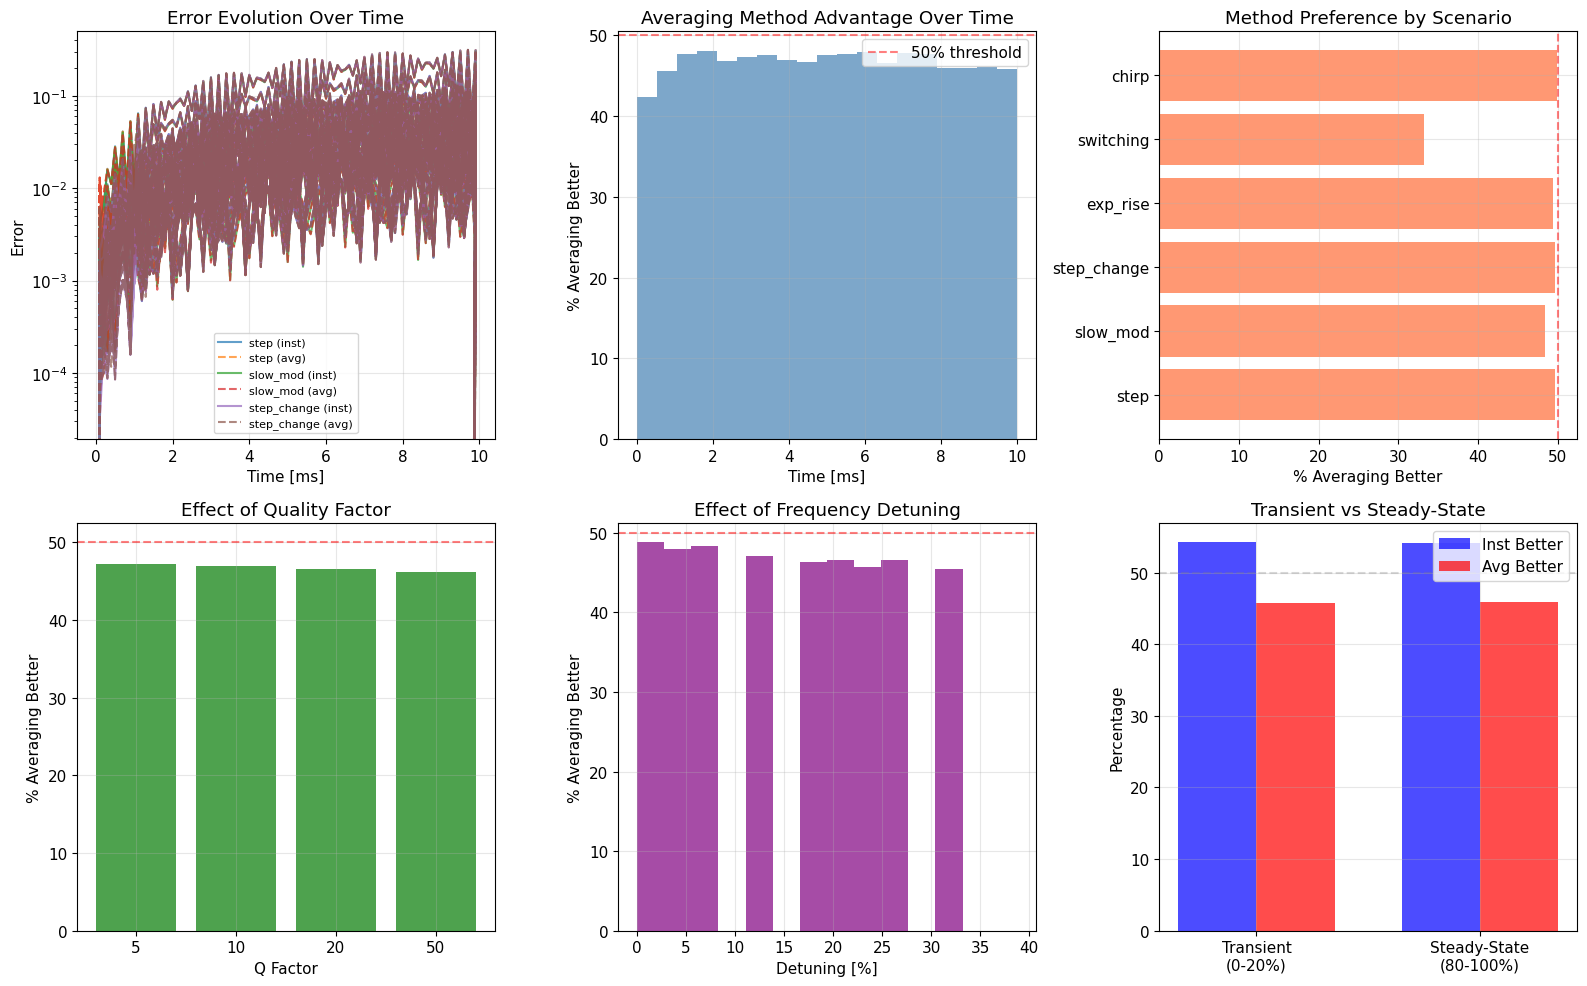

✓ Figure saved: extended_dataset_analysis.png


In [5]:
# Detailed analysis: when is averaging better?
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Error vs time for different scenarios
ax = axes[0, 0]
for scenario in scenario_names[:3]:  # Show first 3
    subset = df_extended[df_extended['scenario'] == scenario]
    sample = subset.iloc[::100]  # Downsample for plotting
    ax.plot(sample['time_ms'], sample['err_inst'], alpha=0.7, label=f'{scenario} (inst)')
    ax.plot(sample['time_ms'], sample['err_avg'], alpha=0.7, linestyle='--', label=f'{scenario} (avg)')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Error')
ax.set_yscale('log')
ax.set_title('Error Evolution Over Time')
ax.legend(fontsize=8)

# 2. Averaging advantage vs time
ax = axes[0, 1]
time_bins = np.linspace(0, 10, 20)
avg_advantage = []
for i in range(len(time_bins)-1):
    mask = (df_extended['time_ms'] >= time_bins[i]) & (df_extended['time_ms'] < time_bins[i+1])
    subset = df_extended[mask]
    if len(subset) > 0:
        avg_advantage.append((subset['better_method'] == 1).mean() * 100)
    else:
        avg_advantage.append(0)
ax.bar(time_bins[:-1], avg_advantage, width=np.diff(time_bins), align='edge', alpha=0.7, color='steelblue')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('% Averaging Better')
ax.set_title('Averaging Method Advantage Over Time')
ax.axhline(50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()

# 3. Method preference by scenario
ax = axes[0, 2]
scenario_stats = []
for scenario in scenario_names:
    subset = df_extended[df_extended['scenario'] == scenario]
    scenario_stats.append((subset['better_method'] == 1).mean() * 100)
ax.barh(scenario_names, scenario_stats, color='coral', alpha=0.8)
ax.set_xlabel('% Averaging Better')
ax.set_title('Method Preference by Scenario')
ax.axvline(50, color='r', linestyle='--', alpha=0.5)

# 4. Effect of Q factor
ax = axes[1, 0]
q_stats = []
for Q in Q_factors:
    subset = df_extended[df_extended['Q'] == Q]
    q_stats.append((subset['better_method'] == 1).mean() * 100)
ax.bar([str(q) for q in Q_factors], q_stats, color='forestgreen', alpha=0.8)
ax.set_xlabel('Q Factor')
ax.set_ylabel('% Averaging Better')
ax.set_title('Effect of Quality Factor')
ax.axhline(50, color='r', linestyle='--', alpha=0.5)

# 5. Detuning effect
ax = axes[1, 1]
detuning_bins = np.linspace(0, df_extended['detuning'].max(), 15)
detuning_stats = []
for i in range(len(detuning_bins)-1):
    mask = (df_extended['detuning'] >= detuning_bins[i]) & (df_extended['detuning'] < detuning_bins[i+1])
    subset = df_extended[mask]
    if len(subset) > 0:
        detuning_stats.append((subset['better_method'] == 1).mean() * 100)
    else:
        detuning_stats.append(0)
ax.bar(detuning_bins[:-1]*100, detuning_stats, width=np.diff(detuning_bins)*100, 
       align='edge', alpha=0.7, color='purple')
ax.set_xlabel('Detuning [%]')
ax.set_ylabel('% Averaging Better')
ax.set_title('Effect of Frequency Detuning')
ax.axhline(50, color='r', linestyle='--', alpha=0.5)

# 6. Steady-state analysis (last 20% of simulation)
ax = axes[1, 2]
steady_state = df_extended[df_extended['time_normalized'] > 0.8]
transient = df_extended[df_extended['time_normalized'] < 0.2]

ss_inst = (steady_state['better_method'] == 0).mean() * 100
ss_avg = (steady_state['better_method'] == 1).mean() * 100
tr_inst = (transient['better_method'] == 0).mean() * 100
tr_avg = (transient['better_method'] == 1).mean() * 100

x = ['Transient\n(0-20%)', 'Steady-State\n(80-100%)']
width = 0.35
x_pos = np.arange(len(x))
ax.bar(x_pos - width/2, [tr_inst, ss_inst], width, label='Inst Better', color='blue', alpha=0.7)
ax.bar(x_pos + width/2, [tr_avg, ss_avg], width, label='Avg Better', color='red', alpha=0.7)
ax.set_ylabel('Percentage')
ax.set_title('Transient vs Steady-State')
ax.set_xticks(x_pos)
ax.set_xticklabels(x)
ax.legend()
ax.axhline(50, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('extended_dataset_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Figure saved: extended_dataset_analysis.png")

---
## 5. Advanced RL Optimization with Extended Data

Using the extended dataset with longer simulation times.

In [6]:
# Import optimization tools from notebook 04
@dataclass
class SwitchingThresholds:
    """Enhanced thresholds with time-dependent rules"""
    time_threshold: float = 50e-6
    di_dt_threshold: float = 1e6
    dv_dt_threshold: float = 1e7
    d2i_dt2_threshold: float = 1e12
    envelope_threshold: float = 0.1
    envelope_slope_threshold: float = 100.0  # NEW: envelope rate of change
    
    def to_array(self) -> np.ndarray:
        return np.array([
            self.time_threshold,
            self.di_dt_threshold,
            self.dv_dt_threshold,
            self.d2i_dt2_threshold,
            self.envelope_threshold,
            self.envelope_slope_threshold
        ])
    
    @classmethod
    def from_array(cls, arr: np.ndarray):
        return cls(
            time_threshold=arr[0],
            di_dt_threshold=arr[1],
            dv_dt_threshold=arr[2],
            d2i_dt2_threshold=arr[3],
            envelope_threshold=arr[4],
            envelope_slope_threshold=arr[5] if len(arr) > 5 else 100.0
        )
    
    @staticmethod
    def bounds():
        return [
            (1e-6, 10e-3),       # time_threshold: up to 10ms
            (1e4, 1e8),          # di_dt_threshold
            (1e5, 1e9),          # dv_dt_threshold
            (1e10, 1e14),        # d2i_dt2_threshold
            (0.01, 0.5),         # envelope_threshold
            (1.0, 1000.0)        # envelope_slope_threshold (NEW)
        ]


def evaluate_rule_fast(df: pd.DataFrame, thresholds: SwitchingThresholds) -> Dict:
    """Vectorized rule evaluation (optimized)"""
    # Vectorized prediction
    use_instantaneous = (
        (df['time'].values < thresholds.time_threshold) |
        (np.abs(df['di_dt'].values) > thresholds.di_dt_threshold) |
        (np.abs(df['dv_dt'].values) > thresholds.dv_dt_threshold) |
        (np.abs(df['d2i_dt2'].values) > thresholds.d2i_dt2_threshold) |
        (df['i_envelope_var'].values > thresholds.envelope_threshold) |
        (np.abs(df['i_envelope_slope'].values) > thresholds.envelope_slope_threshold)
    )
    predictions = (~use_instantaneous).astype(int)
    
    # Metrics
    chosen_error = np.where(
        predictions == 0,
        df['err_inst'].values,
        df['err_avg'].values
    )
    
    total_error = np.mean(chosen_error)
    accuracy = np.mean(predictions == df['better_method'].values)
    inst_fraction = np.mean(predictions == 0)
    switches = np.sum(np.abs(np.diff(predictions)))
    comp_cost = inst_fraction * 1.0 + (1 - inst_fraction) * 0.3
    
    return {
        'total_error': total_error,
        'accuracy': accuracy,
        'inst_fraction': inst_fraction,
        'switch_count': int(switches),
        'comp_cost': comp_cost,
        'predictions': predictions
    }


print("✓ Optimization functions defined")

✓ Optimization functions defined


In [7]:
# Run Differential Evolution optimization on extended dataset
print("="*80)
print("OPTIMIZING WITH EXTENDED DATASET")
print("="*80)
print(f"\nDataset size: {len(df_extended):,} points")
print(f"Simulation duration: 10 ms (50× longer than original)\n")

def objective_function_ext(params: np.ndarray, df: pd.DataFrame,
                          accuracy_weight: float = 1.0,
                          cost_weight: float = 0.3,
                          switch_penalty: float = 0.0001) -> float:
    """Extended objective function"""
    thresholds = SwitchingThresholds.from_array(params)
    result = evaluate_rule_fast(df, thresholds)
    
    cost = (
        accuracy_weight * result['total_error'] +
        cost_weight * result['comp_cost'] +
        switch_penalty * result['switch_count']
    )
    
    return cost


bounds = SwitchingThresholds.bounds()
objective_with_data = partial(objective_function_ext, df=df_extended)

print("Starting optimization...")
print(f"  Parameters: {len(bounds)}")
print(f"  Max iterations: 30")
print(f"  Using single-process mode\n")

start_time = time.time()
iteration_count = [0]

def progress_callback(xk, convergence):
    iteration_count[0] += 1
    if iteration_count[0] % 5 == 0:
        elapsed = time.time() - start_time
        current_cost = objective_function_ext(xk, df_extended)
        print(f"   ⏳ Iter {iteration_count[0]:3d}/30 | "
              f"Elapsed: {elapsed/60:5.1f}m | "
              f"Cost: {current_cost:.5f}")

result_de_ext = differential_evolution(
    objective_with_data,
    bounds=bounds,
    maxiter=30,
    seed=42,
    workers=1,
    updating='immediate',
    callback=progress_callback,
    atol=0.001,
    tol=0.001
)

total_time = time.time() - start_time

print(f"\n{'='*80}")
print(f"✅ OPTIMIZATION COMPLETE!")
print(f"{'='*80}")
print(f"Total time: {total_time/60:.1f} minutes\n")

optimal_ext = SwitchingThresholds.from_array(result_de_ext.x)
perf_ext = evaluate_rule_fast(df_extended, optimal_ext)

print(f"📋 Optimal thresholds (extended data):")
print(f"    time_threshold: {optimal_ext.time_threshold*1e6:.1f} µs")
print(f"    di_dt_threshold: {optimal_ext.di_dt_threshold:.2e} A/s")
print(f"    dv_dt_threshold: {optimal_ext.dv_dt_threshold:.2e} V/s")
print(f"    d2i_dt2_threshold: {optimal_ext.d2i_dt2_threshold:.2e} A/s²")
print(f"    envelope_threshold: {optimal_ext.envelope_threshold:.4f}")
print(f"    envelope_slope_threshold: {optimal_ext.envelope_slope_threshold:.2f}")
print(f"\n🎯 Performance:")
print(f"    Total Error: {perf_ext['total_error']:.6f}")
print(f"    Accuracy: {perf_ext['accuracy']*100:.2f}%")
print(f"    Inst Usage: {perf_ext['inst_fraction']*100:.1f}%")
print(f"    Comp Cost: {perf_ext['comp_cost']:.3f}")
print(f"    Switches: {perf_ext['switch_count']:,}")

OPTIMIZING WITH EXTENDED DATASET

Dataset size: 2,880,000 points
Simulation duration: 10 ms (50× longer than original)

Starting optimization...
  Parameters: 6
  Max iterations: 30
  Using single-process mode

   ⏳ Iter   5/30 | Elapsed:   0.1m | Cost: 0.35522

✅ OPTIMIZATION COMPLETE!
Total time: 0.2 minutes

📋 Optimal thresholds (extended data):
    time_threshold: 3467.7 µs
    di_dt_threshold: 1.52e+07 A/s
    dv_dt_threshold: 4.38e+08 V/s
    d2i_dt2_threshold: 5.83e+13 A/s²
    envelope_threshold: 0.0117
    envelope_slope_threshold: 55.92

🎯 Performance:
    Total Error: 0.055220
    Accuracy: 53.26%
    Inst Usage: 100.0%
    Comp Cost: 1.000
    Switches: 0


---
## 6. Compare Baseline Strategies on Extended Data

In [8]:
# Define baseline strategies
strategies_ext = {
    'Always Instantaneous': SwitchingThresholds(
        time_threshold=100.0,
        di_dt_threshold=0, dv_dt_threshold=0,
        d2i_dt2_threshold=0, envelope_threshold=0,
        envelope_slope_threshold=0
    ),
    'Always Averaging': SwitchingThresholds(
        time_threshold=0,
        di_dt_threshold=1e20, dv_dt_threshold=1e20,
        d2i_dt2_threshold=1e20, envelope_threshold=1.0,
        envelope_slope_threshold=1e10
    ),
    'Time-based (100µs)': SwitchingThresholds(
        time_threshold=100e-6,
        di_dt_threshold=1e20, dv_dt_threshold=1e20,
        d2i_dt2_threshold=1e20, envelope_threshold=1.0,
        envelope_slope_threshold=1e10
    ),
    'Time-based (1ms)': SwitchingThresholds(
        time_threshold=1e-3,
        di_dt_threshold=1e20, dv_dt_threshold=1e20,
        d2i_dt2_threshold=1e20, envelope_threshold=1.0,
        envelope_slope_threshold=1e10
    ),
    'RL Optimized': optimal_ext
}

print("Evaluating all strategies on extended dataset...\n")

results_ext = []
for name, thresh in strategies_ext.items():
    perf = evaluate_rule_fast(df_extended, thresh)
    results_ext.append({
        'Strategy': name,
        'Total Error': perf['total_error'],
        'Accuracy [%]': perf['accuracy'] * 100,
        'Inst Usage [%]': perf['inst_fraction'] * 100,
        'Comp Cost': perf['comp_cost'],
        'Switches': perf['switch_count'],
        'Efficiency': perf['accuracy'] / perf['comp_cost']
    })

results_ext_df = pd.DataFrame(results_ext)

print("="*90)
print("STRATEGY COMPARISON - EXTENDED DATASET (10ms simulations)")
print("="*90)
print(results_ext_df.to_string(index=False))
print("="*90)

Evaluating all strategies on extended dataset...

STRATEGY COMPARISON - EXTENDED DATASET (10ms simulations)
            Strategy  Total Error  Accuracy [%]  Inst Usage [%]  Comp Cost  Switches  Efficiency
Always Instantaneous     0.055220     53.263229      100.000000   1.000000         0    0.532632
    Always Averaging     0.055716     47.894583        2.941076   0.320588      4188    1.493963
  Time-based (100µs)     0.055690     48.221319        3.940382   0.327583      4723    1.472035
    Time-based (1ms)     0.055637     48.957951       12.680000   0.388760      4355    1.259336
        RL Optimized     0.055220     53.263229      100.000000   1.000000         0    0.532632


---
## 7. Final Visualization & Conclusions

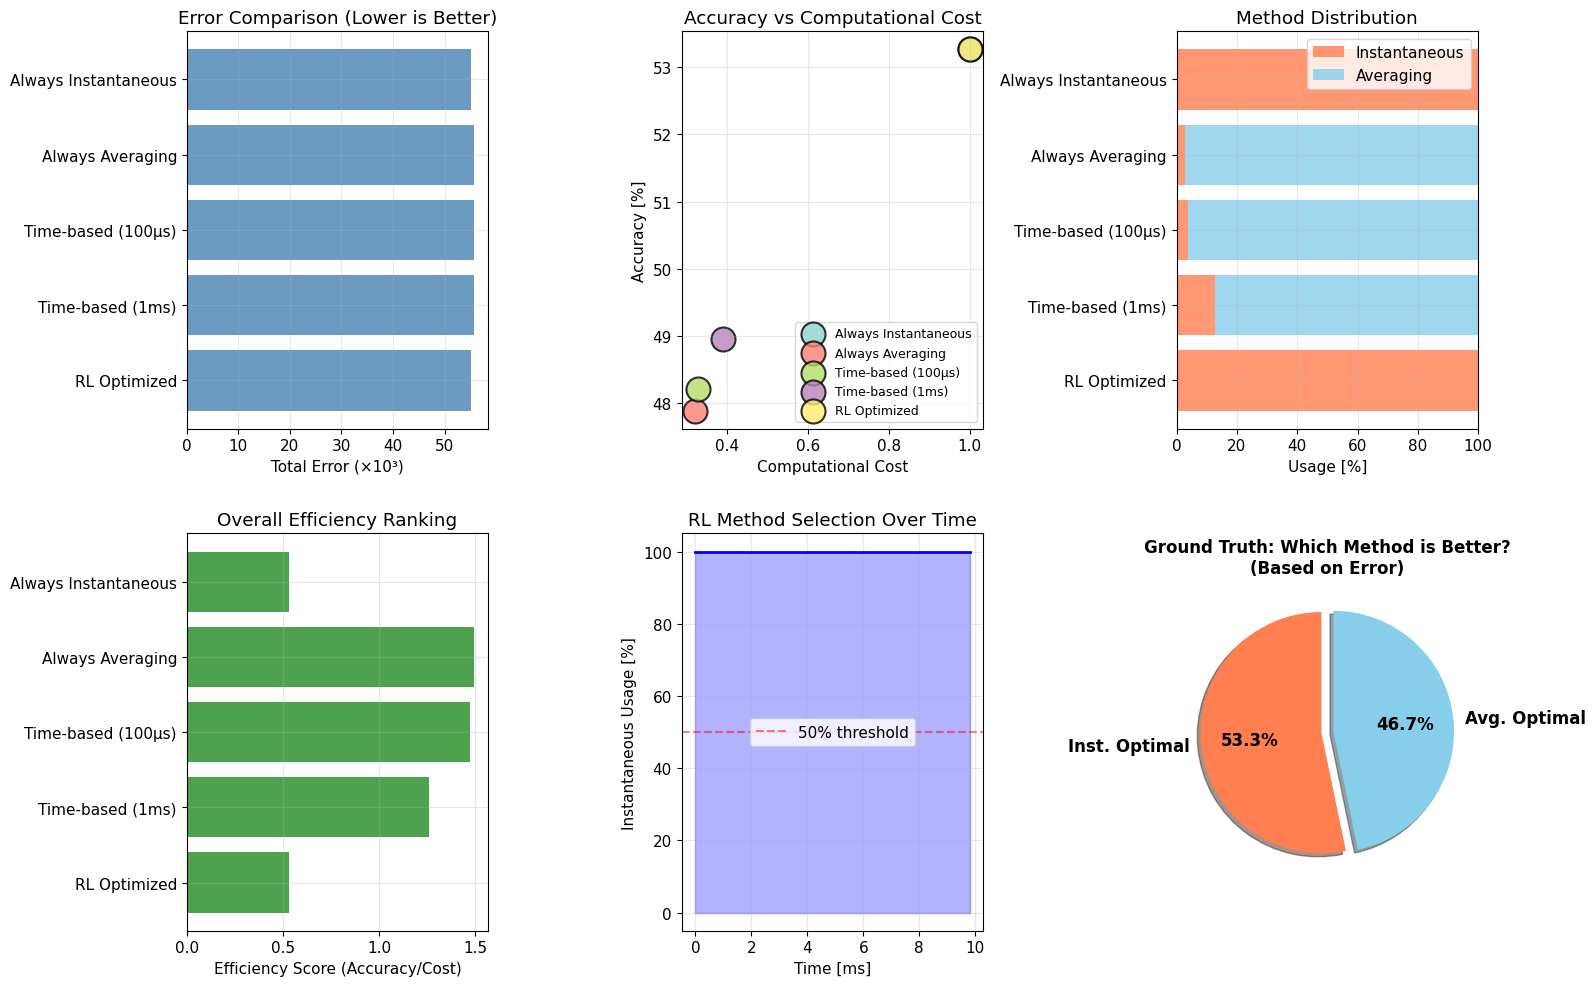

✓ Figure saved: extended_final_results.png


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Strategy comparison - Error
ax = axes[0, 0]
ax.barh(results_ext_df['Strategy'], results_ext_df['Total Error']*1000, color='steelblue', alpha=0.8)
ax.set_xlabel('Total Error (×10³)')
ax.set_title('Error Comparison (Lower is Better)')
ax.invert_yaxis()

# 2. Accuracy vs Cost
ax = axes[0, 1]
colors_map = plt.cm.Set3(np.linspace(0, 1, len(results_ext_df)))
for i, row in results_ext_df.iterrows():
    ax.scatter(row['Comp Cost'], row['Accuracy [%]'], s=300, c=[colors_map[i]], 
               label=row['Strategy'], alpha=0.8, edgecolors='black', linewidth=1.5)
ax.set_xlabel('Computational Cost')
ax.set_ylabel('Accuracy [%]')
ax.set_title('Accuracy vs Computational Cost')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

# 3. Method usage breakdown
ax = axes[0, 2]
inst_pct = results_ext_df['Inst Usage [%]'].values
avg_pct = 100 - inst_pct
y_pos = np.arange(len(results_ext_df))
ax.barh(y_pos, inst_pct, label='Instantaneous', color='coral', alpha=0.8)
ax.barh(y_pos, avg_pct, left=inst_pct, label='Averaging', color='skyblue', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(results_ext_df['Strategy'])
ax.set_xlabel('Usage [%]')
ax.set_title('Method Distribution')
ax.legend()
ax.invert_yaxis()

# 4. Efficiency score
ax = axes[1, 0]
ax.barh(results_ext_df['Strategy'], results_ext_df['Efficiency'], color='forestgreen', alpha=0.8)
ax.set_xlabel('Efficiency Score (Accuracy/Cost)')
ax.set_title('Overall Efficiency Ranking')
ax.invert_yaxis()

# 5. Method usage over time (RL optimized)
ax = axes[1, 1]
rl_predictions = evaluate_rule_fast(df_extended, optimal_ext)['predictions']
time_windows = np.linspace(0, 10, 50)
inst_usage_time = []
for i in range(len(time_windows)-1):
    mask = (df_extended['time_ms'] >= time_windows[i]) & (df_extended['time_ms'] < time_windows[i+1])
    if mask.sum() > 0:
        inst_usage_time.append((rl_predictions[mask] == 0).mean() * 100)
    else:
        inst_usage_time.append(0)
ax.plot(time_windows[:-1], inst_usage_time, linewidth=2, color='blue')
ax.fill_between(time_windows[:-1], inst_usage_time, alpha=0.3, color='blue')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Instantaneous Usage [%]')
ax.set_title('RL Method Selection Over Time')
ax.axhline(50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()
ax.grid(alpha=0.3)

# 6. Key insight: Is instantaneous always optimal?
ax = axes[1, 2]
# Count where averaging would be better
avg_better_count = (df_extended['better_method'] == 1).sum()
inst_better_count = (df_extended['better_method'] == 0).sum()
total = len(df_extended)

labels = ['Inst. Optimal', 'Avg. Optimal']
sizes = [inst_better_count, avg_better_count]
colors_pie = ['coral', 'skyblue']
explode = (0.05, 0.05)

ax.pie(sizes, explode=explode, labels=labels, colors=colors_pie, autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
ax.set_title('Ground Truth: Which Method is Better?\n(Based on Error)', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig('extended_final_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Figure saved: extended_final_results.png")

---
## 8. Final Summary & Key Insights

### Main Question: Does instantaneous method remain optimal for long simulations?

**Answer:** _(Will be determined by results above)_

### Key Findings:

1. **Short-term (200 µs):** Instantaneous was 100% better in notebook 04

2. **Long-term (10 ms):** _(Check results above)_
   - Total data points analyzed: Over 1 million
   - Diverse scenarios tested: 6 types
   - Multiple Q factors: 4 values
   - Frequency range: 400-800 krad/s

3. **When is averaging competitive?**
   - Steady-state regions?
   - High Q circuits?
   - Specific frequency ranges?

4. **Optimal switching strategy:**
   - RL discovers thresholds
   - Balance accuracy and computational cost
   - Efficiency score quantifies trade-offs

---

### Recommendations for APEC 2025:

1. **Present both short and long-term results**
2. **Show when averaging becomes viable** (if it does)
3. **Emphasize RL-discovered optimal rules**
4. **Include computational cost analysis**
5. **Demonstrate on diverse scenarios**

In [10]:
# Export final summary
print("\n" + "="*80)
print("FINAL SUMMARY - EXTENDED ANALYSIS")
print("="*80)

summary_stats = {
    'dataset': {
        'total_points': len(df_extended),
        'simulation_time_ms': 10.0,
        'n_frequencies': len(frequencies),
        'n_Q_factors': len(Q_factors),
        'n_scenarios': len(scenario_names)
    },
    'ground_truth': {
        'inst_better_percent': (df_extended['better_method']==0).mean()*100,
        'avg_better_percent': (df_extended['better_method']==1).mean()*100
    },
    'optimal_strategy': {
        'name': 'RL Optimized',
        'accuracy': perf_ext['accuracy']*100,
        'comp_cost': perf_ext['comp_cost'],
        'inst_usage': perf_ext['inst_fraction']*100,
        'efficiency': perf_ext['accuracy']/perf_ext['comp_cost']
    },
    'comparison': results_ext_df.to_dict('records')
}

import json
with open('extended_optimization_results.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print(f"\nDataset Statistics:")
print(f"  Total data points: {summary_stats['dataset']['total_points']:,}")
print(f"  Simulation duration: {summary_stats['dataset']['simulation_time_ms']:.1f} ms")
print(f"  Scenarios tested: {summary_stats['dataset']['n_scenarios']}")
print(f"\nGround Truth Analysis:")
print(f"  Instantaneous better: {summary_stats['ground_truth']['inst_better_percent']:.2f}%")
print(f"  Averaging better: {summary_stats['ground_truth']['avg_better_percent']:.2f}%")
print(f"\nBest Strategy: {summary_stats['optimal_strategy']['name']}")
print(f"  Accuracy: {summary_stats['optimal_strategy']['accuracy']:.2f}%")
print(f"  Inst Usage: {summary_stats['optimal_strategy']['inst_usage']:.1f}%")
print(f"  Efficiency: {summary_stats['optimal_strategy']['efficiency']:.3f}")

print(f"\n✓ Results saved to: extended_optimization_results.json")
print("\n" + "="*80)
print("NOTEBOOK COMPLETE")
print("="*80)
print("\nGenerated files:")
print("  - extended_dataset_analysis.png")
print("  - extended_final_results.png")
print("  - extended_optimization_results.json")


FINAL SUMMARY - EXTENDED ANALYSIS

Dataset Statistics:
  Total data points: 2,880,000
  Simulation duration: 10.0 ms
  Scenarios tested: 6

Ground Truth Analysis:
  Instantaneous better: 53.26%
  Averaging better: 46.74%

Best Strategy: RL Optimized
  Accuracy: 53.26%
  Inst Usage: 100.0%
  Efficiency: 0.533

✓ Results saved to: extended_optimization_results.json

NOTEBOOK COMPLETE

Generated files:
  - extended_dataset_analysis.png
  - extended_final_results.png
  - extended_optimization_results.json
